In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import os
from rlway.pyosrd.osrd import OSRD

In [42]:
sim = OSRD(use_case='c1', dir='tmp')

[10:55:49,623] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[10:55:49,654] [INFO]              [FullInfra] parsing infra
[10:55:49,710] [INFO]              [FullInfra] adaptation to kotlin
[10:55:49,738] [INFO]              [FullInfra] loading signals
[10:55:49,743] [INFO]              [FullInfra] building blocks
[10:55:49,748] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/simulation.json
[10:55:49,761] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.6
[10:55:49,807] [DEBUG]             [Allowance] computing range n°1
[10:55:49,809] [DEBUG]             [Allowance]   computing section n°1
[10:55:49,809] [DEBUG]             [Allowance]   target time = 274.13399999999996
[10:55:49,809] [DEBUG]             [Allowance]     starting attempt 1
[10:55:49,811] [DEBUG]             [Allowance]     envelope time 452.323
[10:55:49,811] [DEBUG]             [Allowance]     starting attempt 2
[10:55:49,811] [DEBUG]             [Allow

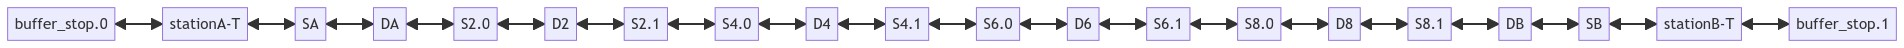

In [43]:
sim.draw_infra_points()

In [44]:
sim.reset_delays()

In [45]:
sim.trains

['First train', 'Second train']

In [46]:
sim.add_delay('First train', time_threshold=50, delay=300.)
delayed = sim.delayed()

In [47]:
from rlway.pyosrd.agents.agent import DoNothing, Agent

In [48]:
from dataclasses import dataclass
from typing import List, Dict, Any

@dataclass
class AddStop(Agent):
    train: int
    position: float
    duration: float

    def stops(self, osrd) -> List[Dict[str, Any]]:
        print(self.delayed)
        return [{
            'train': self.train,
            'position': self.position,
            'duration': self.duration,
        }]

In [49]:
# regulated = sim.regulate(agent=AddStop('name', 1, 100, 200))
regulated = sim.regulate(agent=DoNothing('nothing'))

[10:55:50,842] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[10:55:50,873] [INFO]              [FullInfra] parsing infra
[10:55:50,929] [INFO]              [FullInfra] adaptation to kotlin
[10:55:50,954] [INFO]              [FullInfra] loading signals
[10:55:50,960] [INFO]              [FullInfra] building blocks
[10:55:50,965] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/delayed/nothing/simulation.json
[10:55:50,977] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.6
[10:55:51,025] [DEBUG]             [Allowance] computing range n°1
[10:55:51,027] [DEBUG]             [Allowance]   computing section n°1
[10:55:51,027] [DEBUG]             [Allowance]   target time = 274.13399999999996
[10:55:51,028] [DEBUG]             [Allowance]     starting attempt 1
[10:55:51,029] [DEBUG]             [Allowance]     envelope time 452.323
[10:55:51,029] [DEBUG]             [Allowance]     starting attempt 2
[10:55:51,030] [DEBUG]   

In [54]:
import matplotlib.pyplot as plt
points_to_show = ['switch', 'departure', 'switch', 'arrival', 'station']
fig1 = sim.space_time_chart_plotly(0, points_to_show=points_to_show)
fig2 = delayed.space_time_chart_plotly(0, points_to_show=points_to_show)
fig3 = regulated.space_time_chart_plotly(0, points_to_show=points_to_show)

In [55]:
fig1.show()
fig2.show()
fig3.show()

In [52]:
from rlway.schedules import schedule_from_osrd

s = schedule_from_osrd(sim)
sd = schedule_from_osrd(delayed)
sr = schedule_from_osrd(regulated)

<Axes: xlabel='Time'>

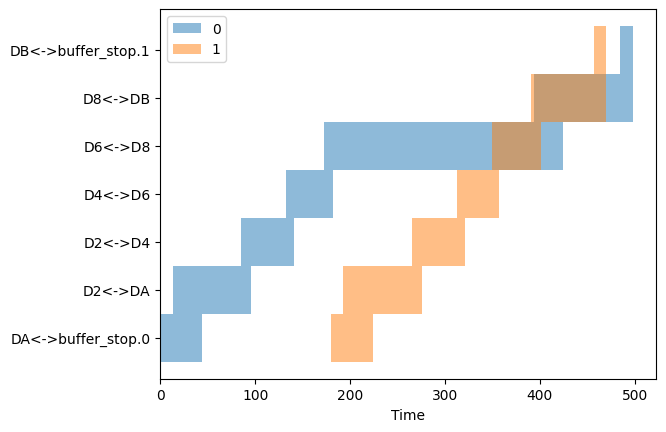

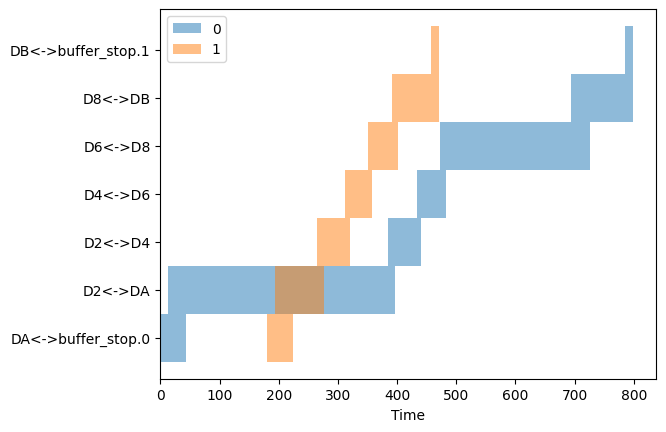

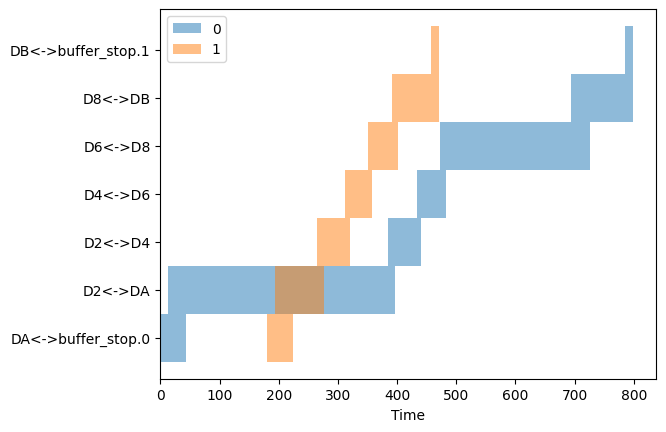

In [53]:
s.plot()
sd.plot()
sr.plot()